<a href="https://colab.research.google.com/github/umd-fire-coml/2022-t3-vector-quantization/blob/main/VQ_VAE_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-probability


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf


In [ ]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [ ]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(140,1, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [ ]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(140,1, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_88 (InputLayer)       [(None, 140, 1, 1)]       0         
                                                                 
 encoder (Functional)        (None, 35, 1, 16)         19856     
                                                                 
 vector_quantizer (VectorQua  (None, 35, 1, 16)        1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 140, 4, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [ ]:
!git clone https://github.com/mdeff/fma.git


Cloning into 'fma'...
remote: Enumerating objects: 823, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 823 (delta 6), reused 10 (delta 3), pack-reused 808
Receiving objects: 100% (823/823), 4.08 MiB | 28.84 MiB/s, done.
Resolving deltas: 100% (528/528), done.


In [ ]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  15.3M      0  0:00:22  0:00:22 --:--:-- 19.1M


In [ ]:
!echo "f0df49ffe5f2a6008d7dc83c6915b31835dfe733  fma_metadata.zip" | sha1sum -c -
!7z e fma_metadata.zip

fma_metadata.zip: OK

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 358412441 bytes (342 MiB)

Extracting archive: fma_metadata.zip
--
Path = fma_metadata.zip
Type = zip
Physical Size = 358412441

  0%      0% 4 - fma_metadata/raw_albums.csv                                      1% 4 - fma_metadata/raw_albums.csv                                      1% 5        1% 5 - fma_metadata/raw_artists.csv                                       2% 5 - fma_metadata/raw_artists.csv                         

In [ ]:
cd fma

/content/fma


In [ ]:
!pip install py7zr
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.6 MB/s 
     |████████████████████████████████| 357 kB 17.6 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 2.3 MB 65.6 MB/s 
     |████████████████████████████████| 139 kB 39.6 MB/s 
     |████████████████████████████████| 378 kB 60.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import os

import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

import utils

In [ ]:
cd ..

/content


In [ ]:
tracks = utils.load('tracks.csv')
features = utils.load('features.csv')
echonest = utils.load('echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

((106574, 52), (106574, 518), (13129, 249))

In [ ]:
print(features['mfcc'])


statistics   kurtosis                                                    \
number             01        02        03        04        05        06   
track_id                                                                  
2            3.856789  1.541901  0.000816  0.330728  0.118731 -0.342687   
3            4.296755  1.399977  0.112535 -0.211170  0.032953 -0.023489   
5            2.624517  2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10           5.076893  1.161854  2.095651  1.372743 -0.203574 -0.345354   
20          11.880132  4.085320  0.002655  1.518562  0.181947  0.339014   
...               ...       ...       ...       ...       ...       ...   
155316       4.895152  5.361988  3.186483  0.510951 -0.143080  0.342237   
155317       0.040857  1.752112  0.442188 -0.380960 -0.739809 -0.023362   
155318       0.581889 -0.129386  0.662489  1.025676  0.170532  1.827692   
155319       5.164501  3.716359  2.881116  3.273014  0.707058  1.951918   
155320       4.619462  1.

In [ ]:
import numpy as np

print(np.newaxis is None)


True


In [ ]:
x_train = features['mfcc'].to_numpy()
x_test = features['mfcc']
x_train = np.expand_dims(x_train, -1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

x_train.shape, x_test.shape


((106574, 140, 1, 1), (106574, 140, 1, 1))

In [ ]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)


Epoch 1/30
833/833 [==============================] - 133s 158ms/step - loss: 4.8297 - reconstruction_loss: 0.4771 - vqvae_loss: 3.8384
Epoch 2/30
833/833 [==============================] - 133s 160ms/step - loss: 1.2777 - reconstruction_loss: 0.0812 - vqvae_loss: 1.1654
Epoch 3/30
833/833 [==============================] - 127s 153ms/step - loss: 0.2258 - reconstruction_loss: 0.0418 - vqvae_loss: 0.1800
Epoch 4/30
833/833 [==============================] - 124s 148ms/step - loss: 0.1538 - reconstruction_loss: 0.0352 - vqvae_loss: 0.1171
Epoch 5/30
833/833 [==============================] - 128s 153ms/step - loss: 0.1345 - reconstruction_loss: 0.0302 - vqvae_loss: 0.1031
Epoch 6/30
833/833 [==============================] - 123s 148ms/step - loss: 0.1092 - reconstruction_loss: 0.0254 - vqvae_loss: 0.0824
Epoch 7/30
833/833 [==============================] - 120s 144ms/step - loss: 0.0986 - reconstruction_loss: 0.0232 - vqvae_loss: 0.0752
Epoch 8/30
833/833 [============================

In [ ]:
import librosa
import librosa.display


In [ ]:
trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    print(test_image)
    print(reconstructed_image)

Streaming output truncated to the last 5000 lines.

 [[-0.49816164]
  [-0.499387  ]
  [-0.49950004]
  [-0.49790373]]

 [[-0.48788506]
  [-0.48884445]
  [-0.4971257 ]
  [-0.49773848]]

 [[-0.36499152]
  [-0.36631364]
  [-0.36434862]
  [-0.3637404 ]]

 [[-0.4165391 ]
  [-0.41455865]
  [-0.41935045]
  [-0.422125  ]]

 [[-0.42176354]
  [-0.42183602]
  [-0.4242839 ]
  [-0.42262754]]

 [[-0.4310663 ]
  [-0.42961723]
  [-0.43213916]
  [-0.42991897]]

 [[-0.4407177 ]
  [-0.43558046]
  [-0.43897325]
  [-0.4374817 ]]

 [[-0.43363845]
  [-0.43300194]
  [-0.4324058 ]
  [-0.43407455]]

 [[-0.44302052]
  [-0.443372  ]
  [-0.44592518]
  [-0.4451363 ]]

 [[-0.4552206 ]
  [-0.45590976]
  [-0.45439118]
  [-0.45581168]]

 [[-0.46245486]
  [-0.46169382]
  [-0.46297568]
  [-0.46255374]]

 [[-0.4647808 ]
  [-0.4639943 ]
  [-0.4637295 ]
  [-0.46477142]]

 [[-0.46556753]
  [-0.46533367]
  [-0.4652092 ]
  [-0.46441635]]

 [[-0.46717733]
  [-0.46707147]
  [-0.46741968]
  [-0.46624953]]

 [[-0.46705168]
  [-0.46

1/1 [==============================] - 0s 24ms/step


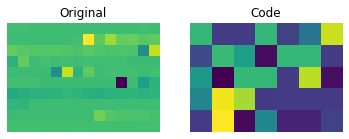

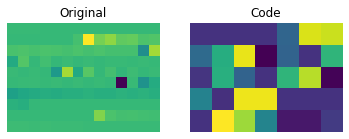

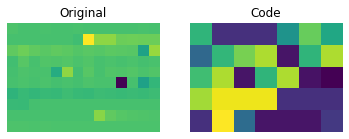

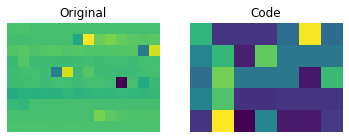

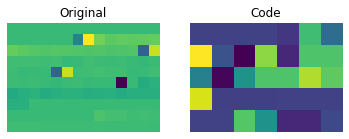

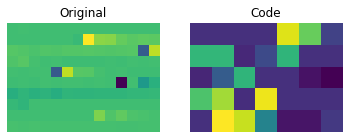

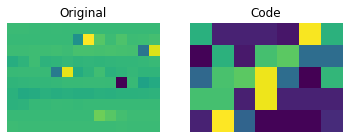

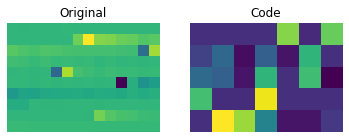

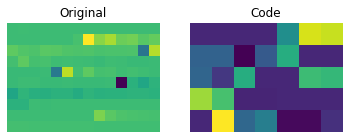

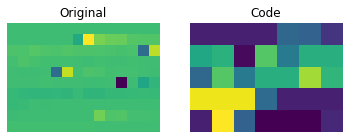

In [ ]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].reshape(10,14))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i].reshape(5,7))
    plt.title("Code")
    plt.axis("off")
    plt.show()


In [ ]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")


Input shape of the PixelCNN: (35, 1)


In [ ]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()


Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_93 (InputLayer)       [(None, 35, 1)]           0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 35, 1, 128)        0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 35, 1, 128)       802944    
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 35, 1, 128)       98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 35, 1, 128)       98624     
 lock)                                                           
                                                         

In [ ]:
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")


3331/3331 [==============================] - 15s 4ms/step
Shape of the training data for PixelCNN: (106574, 35, 1)


In [ ]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=30,
    validation_split=0.1,
)


Epoch 1/30
750/750 [==============================] - 416s 553ms/step - loss: 1.8608 - accuracy: 0.4886 - val_loss: 1.2607 - val_accuracy: 0.5757
Epoch 2/30
750/750 [==============================] - 401s 535ms/step - loss: 1.1747 - accuracy: 0.5990 - val_loss: 1.1474 - val_accuracy: 0.6054
Epoch 3/30
750/750 [==============================] - 394s 526ms/step - loss: 1.1019 - accuracy: 0.6181 - val_loss: 1.0980 - val_accuracy: 0.6182
Epoch 4/30
750/750 [==============================] - 401s 535ms/step - loss: 1.0688 - accuracy: 0.6253 - val_loss: 1.0700 - val_accuracy: 0.6248
Epoch 5/30
750/750 [==============================] - 395s 527ms/step - loss: 1.0514 - accuracy: 0.6285 - val_loss: 1.0601 - val_accuracy: 0.6254
Epoch 6/30
750/750 [==============================] - 398s 531ms/step - loss: 1.0409 - accuracy: 0.6305 - val_loss: 1.0569 - val_accuracy: 0.6256
Epoch 7/30
750/750 [==============================] - 398s 531ms/step - loss: 1.0339 - accuracy: 0.6315 - val_loss: 1.0466 -

KeyboardInterrupt: ignored

In [ ]:
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)


In [ ]:
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")


1/1 [==============================] - 0s 100ms/step
Prior shape: (10, 35, 1)


1/1 [==============================] - 0s 61ms/step


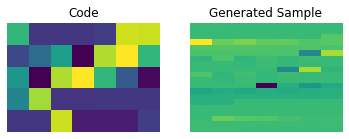

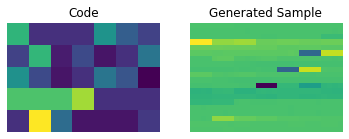

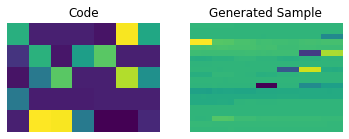

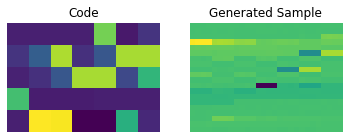

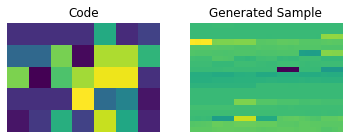

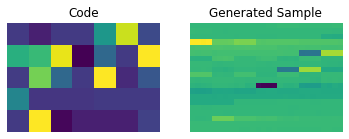

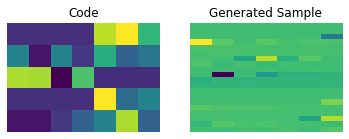

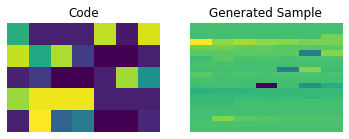

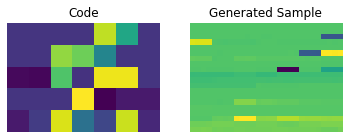

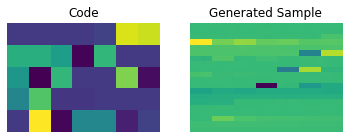

In [ ]:
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i].reshape(5,7))
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].reshape(20,28))
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()




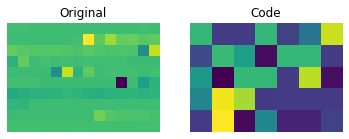

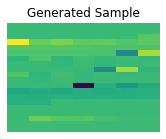

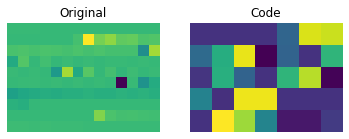

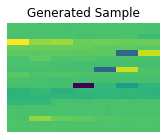

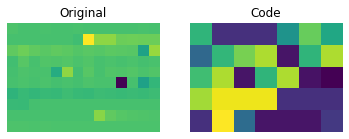

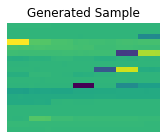

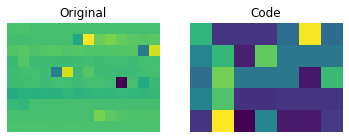

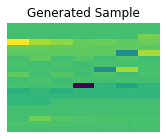

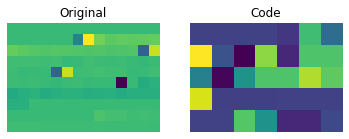

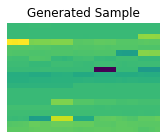

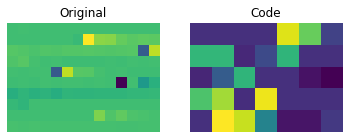

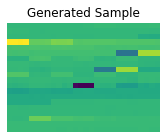

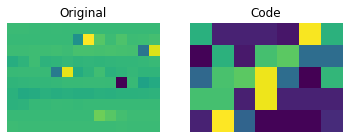

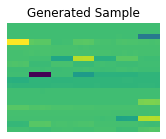

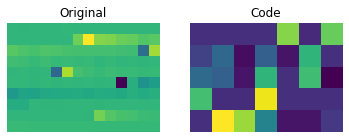

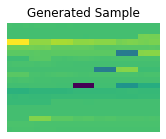

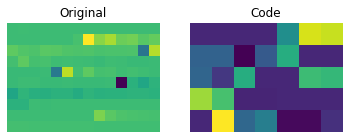

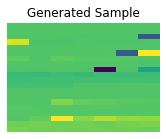

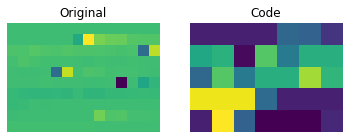

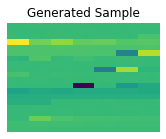

In [ ]:
for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].reshape(10,14))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i].reshape(5,7))
    plt.title("Code")
    plt.axis("off")
    plt.show()

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].reshape(20,28))
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()


    


In [ ]:
librosa.feature.inverse.mfcc_to_audio(generated_samples[0].squeeze())


array([ 0.00195458, -0.21453696,  0.17013216, ..., -0.22554962,
        0.03372858,  0.03351924], dtype=float32)